In [9]:
import torch
#from diffusers import FluxPipeline
from pipeline_p2p_flux import FluxPrompt2PromptPipeline as FluxPipeline
from pipeline_p2p_flux import AttentionStore

pipe = FluxPipeline.from_pretrained("/home/frain/Documents/FLUX.1-dev", torch_dtype=torch.bfloat16)
pipe.enable_sequential_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 105.52it/s]t/s]
You are using a model of type clip_text_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


In [10]:
num_inference_steps = 20
controller = AttentionStore(
    len(pipe.transformer.transformer_blocks),
    len(pipe.transformer.single_transformer_blocks),
    num_inference_steps,
)
controller.register_attention_control(pipe)

prompt = "An astronaut pinpointing a flag that says hello world on the surface of Mars, digital art"
image = pipe(
    prompt,
    height=1024,
    width=1024,
    guidance_scale=3.5,
    num_inference_steps=num_inference_steps,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]

100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


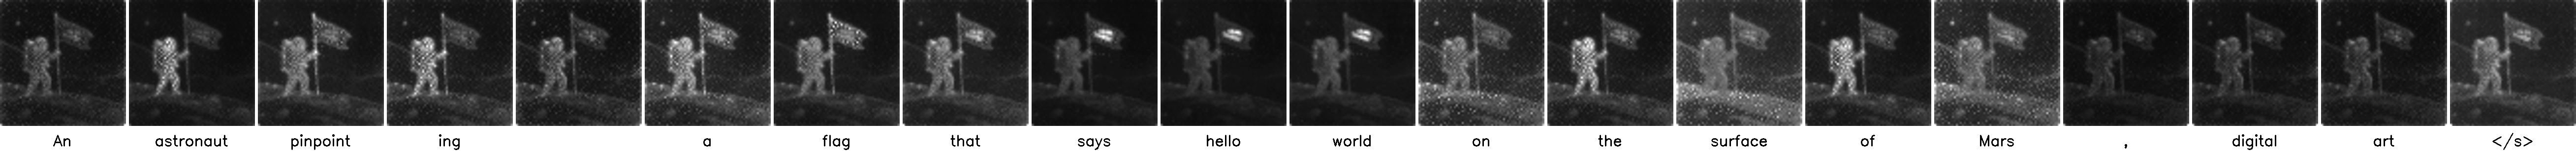

In [12]:
from PIL import Image, ImageDraw, ImageFont
from typing import Optional, Union, Tuple, List, Callable, Dict
import cv2

def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img


def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)

def show_cross_attention(attention_maps, tokens, decoder):
    images = []
    for i in range(len(tokens)):
        #ipdb.set_trace()
        image = attention_maps[i, :].reshape(64, 64)
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    view_images(np.stack(images, axis=0))

show_cross_attention(controller.attention_store.to(dtype=torch.float32).cpu().float(), tokens, pipe.tokenizer_2.decode)

In [8]:
# release memory
del pipe.controller
del pipe
import torch
torch.cuda.empty_cache()

NameError: name 'pipe' is not defined